# Balanceo de datasets

Para este ejemplo usaremos el dataset de [Detección de fraudes con tarjetas de crédito](https://www.kaggle.com/mlg-ulb/creditcardfraud/data).

Este dataset consta de 285.000 filas con 31 columnas (features).

Como la información es privada, no sabemos realmente que significan los features y están nombradas como V1, V2, V3, etc. excepto por las columnas Time y Amount (el importe de la transacción). Y nuestras clases son 0 y 1 correspondiendo con “transacción Normal” ó “Hubo Fraude”.

Como podrán imaginar, el set de datos está muy desequilibrado y tendremos muy pocas muestras etiquetadas como fraude.

En esta ocasion no centraremos tanto en la elección del modelo ni en su configuración. En su lugar nos centraremos en aplicar diversas estrategias para mejorar los resultados a pesar del desequilibrio de clases.

In [1]:
!pip install -U imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.0 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier

from pylab import rcParams

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

In [4]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/42395-data-science/AfterClass/01 - Balanceo de datasets

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1RN4ip2C-gF9o1bLuUKCTkIyVsFazkElA/42395-data-science/AfterClass/01 - Balanceo de datasets


In [5]:
df = pd.read_csv("creditcard.csv") # read in data downloaded to the local directory
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
print(df.shape)
print(pd.value_counts(df['Class'], sort = True)/len(df))

(284807, 31)
0    0.998273
1    0.001727
Name: Class, dtype: float64


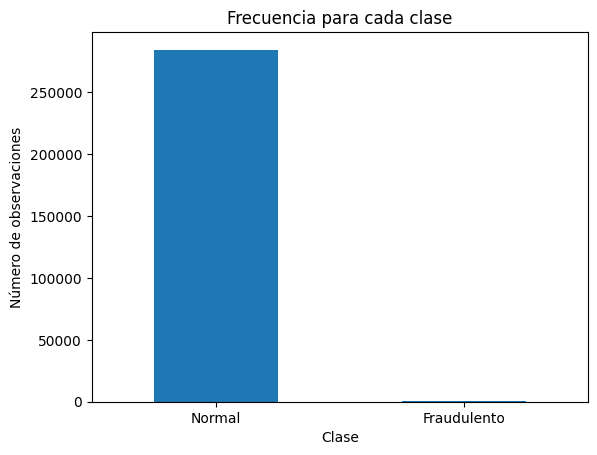

In [7]:
LABELS = ["Normal", "Fraudulento"]
count_classes = pd.value_counts(df['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title("Frecuencia para cada clase")
plt.xlabel("Clase")
plt.ylabel("Número de observaciones");

## Estrategias para el manejo de datos desbalanceados

### Ajuste de parámetros del modelo

El primer intento es ajustar los parámetros ó metricas del propio algoritmo para intentar equilibrar a la clase minoritaria penalizando a la clase mayoritaria durante el entrenamiento. Por ejemplo, en los árboles de clasificación existe el parámetro "class_weight='balanced'". No todos los algoritmos tienen esta posibilidad.

### Modificar el dataset

Podemos eliminar muestras de la clase mayoritaria, para reducirlo e intentar equilibrar la situación. Pero tiene el riesgo de perder información valiosa para el entrenamiento del modelo. Otra alternativa sería agregar nuevas filas con los valores de las clases minoritarias, sin embargo, esto puede llevar a overfitting.

### Muestras artificiales

Un intento más sofisticado es crear muestras sintéticas utilizando diversos algoritmos que intentan seguir la tendencia del grupo minoritario. El riesgo es alterar la distribución "natural" de la clase minoritaria y confundir al modelo.

### Ensamble de métodos de balanceo

Entrena diversos modelos y entre todos se obtiene el resultado final, pero se asegura de tomar muestras de entrenamiento equilibradas.


-----


## Modelo base

Como modelo vainilla usaremos una regresión logistica (recordemos que es algoritmo de clasificación a pesar del nombre).

In [8]:
#definimos nuestras etiquetas y features
y = df['Class']
X = df.drop('Class', axis=1)

#dividimos en sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7)

#creamos una función que crea el modelo que usaremos cada vez
def run_model(X_train, X_test, y_train, y_test):
    clf_base = LogisticRegression(C=1.0, penalty='l2',random_state=1, solver="newton-cg")
    clf_base.fit(X_train, y_train)
    return clf_base

#ejecutamos el modelo "tal cual"
model = run_model(X_train, X_test, y_train, y_test)

#definimos funciona para mostrar los resultados
def mostrar_resultados(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y)
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
    plt.title("Confusion matrix")
    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.show()

/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


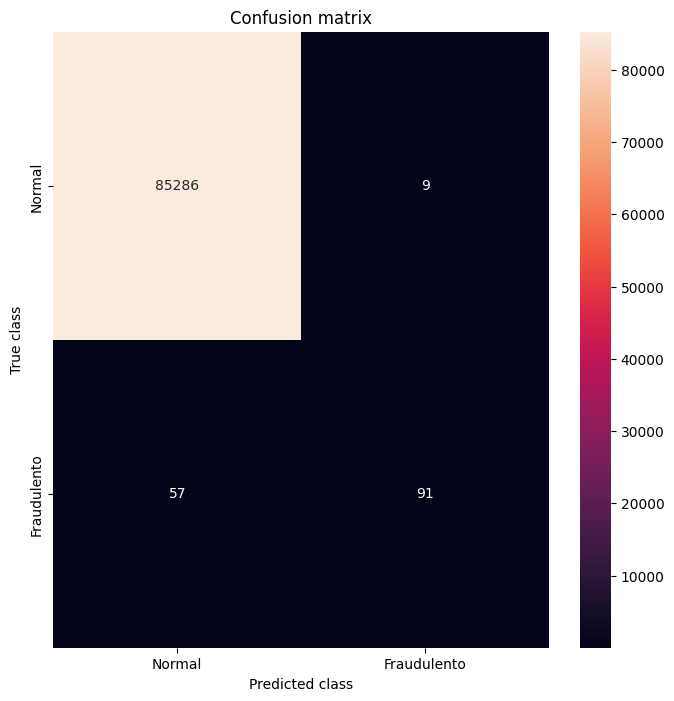

In [9]:
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [10]:
print(classification_report(y_test, pred_y,target_names=LABELS))

              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     85295
 Fraudulento       0.91      0.61      0.73       148

    accuracy                           1.00     85443
   macro avg       0.95      0.81      0.87     85443
weighted avg       1.00      1.00      1.00     85443



Basados en la matriz de confusión notamos, existen 76 fallos (este puede variar en cada entrenamiento) y 87 aciertos en la clase minoritaria (este también depende del entrenamiento) dando como resultado un recall de 0.53 y es el valor que queremos mejorar. Es importante notar que aunque los resultados de f1 score no son alarmantes, el modelo no es capaz de detectar correctamente los casos de fraude.

### Penalizando para compensar

Usando el parámetro adicional "weight" en el modelo de Regresión logística, lo confguramos en "balanced", con esto el algoritmo se encargará de equilibrar a la clase minoritaria durante el entrenamiento

/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


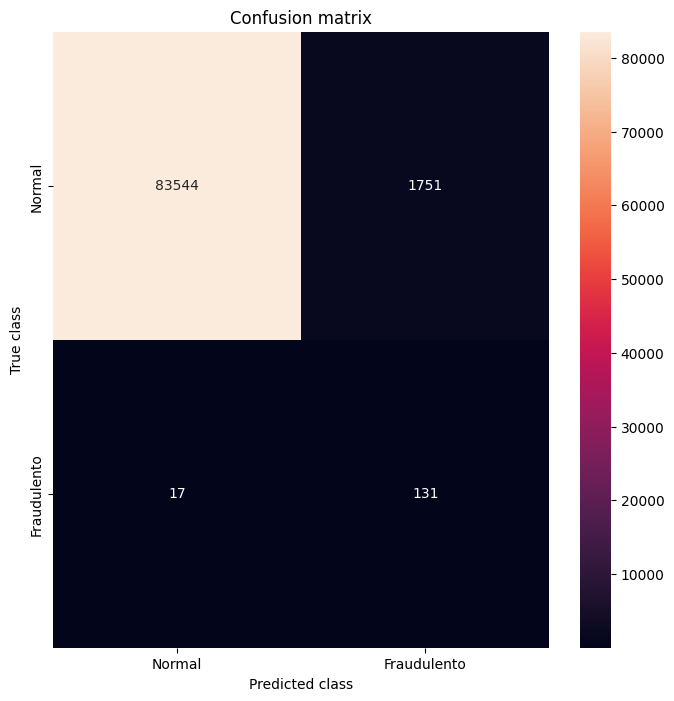

In [11]:
def run_model_balanced(X_train, X_test, y_train, y_test):
    clf = LogisticRegression(C=1.0,penalty='l2',random_state=1,solver="newton-cg",class_weight="balanced")
    clf.fit(X_train, y_train)
    return clf

model = run_model_balanced(X_train, X_test, y_train, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [12]:
print(classification_report(y_test, pred_y,target_names=LABELS))

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     85295
 Fraudulento       0.07      0.89      0.13       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443



Ahora vemos una NOTABLE MEJORA! en la clase minoritaria -que indica si hubo fraude-, se han acertado 146 muestras y fallado en 17, dando un recall de 0.90  y sólo con agregar un parámetro al modelo 😉. También notemos que en la columna de f1-score parecería que hubieran “empeorado” los resultado, cuando realmente estamos mejorando la detección de casos fraudulentos. Es cierto que aumentan los Falsos Positivos y se han etiquetado 1957 muestras como fraudulentas cuando no lo era, pero ¿qué prefiere la compañía bancaria, tener que revisar esos casos manualmente ó fallar en detectar los verdaderos casos de fraude?


### Subsampling en la clase mayoritaria

Utilizaremos un algoritmo para reducir la clase mayoritaria, lo haremos usando un algoritmo similar a KKN para ir seleccionando cuales eliminar.

Distribución antes de resampleo Counter({0: 199020, 1: 344})
Distribución después del resampleo Counter({0: 688, 1: 344})


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:457: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


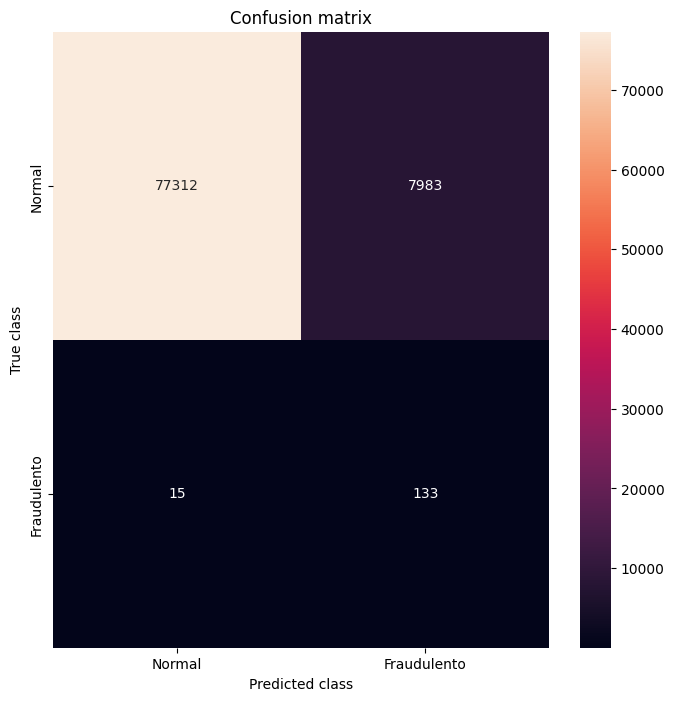

In [13]:
us = NearMiss( sampling_strategy=0.5, n_neighbors=3, version=2)

X_train_res, y_train_res = us.fit_resample(X_train, y_train)

print ("Distribución antes de resampleo {}".format(Counter(y_train)))
print ("Distribución después del resampleo {}".format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [14]:
print(classification_report(y_test, pred_y,target_names=LABELS))

              precision    recall  f1-score   support

      Normal       1.00      0.91      0.95     85295
 Fraudulento       0.02      0.90      0.03       148

    accuracy                           0.91     85443
   macro avg       0.51      0.90      0.49     85443
weighted avg       1.00      0.91      0.95     85443



También obtenemos un buen resultado para el recall de 0.88, a costa de aumentar los falsos positivos.


### Oversampling de la clase minoritaria


En este caso, crearemos muestras nuevas “sintéticas” de la clase minoritaria. Usando RandomOverSampler.

Distribución antes de resampleo Counter({0: 199020, 1: 344})
Distribución despues de resampleo Counter({0: 199020, 1: 99510})


/usr/local/lib/python3.10/dist-packages/sklearn/utils/optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(


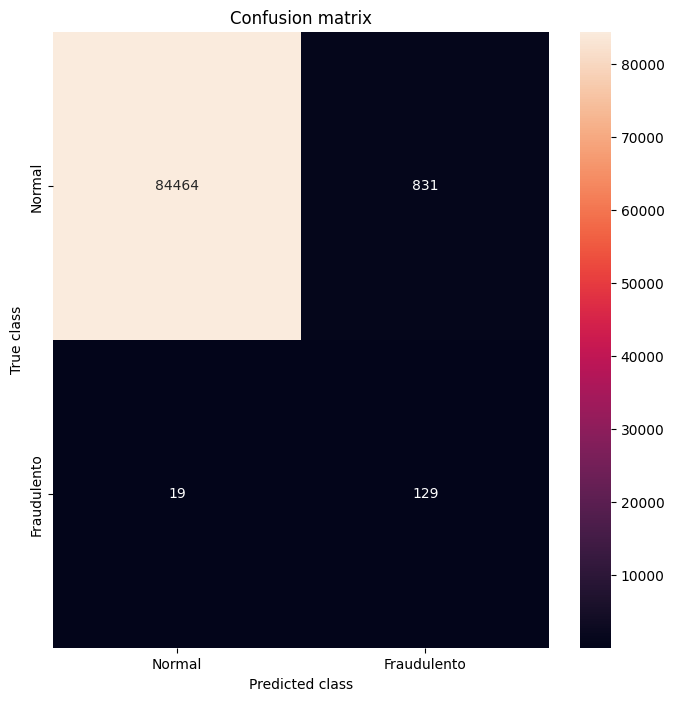

In [15]:
os =  RandomOverSampler(sampling_strategy=0.5,)
X_train_res, y_train_res = os.fit_resample(X_train, y_train)

print ("Distribución antes de resampleo {}".format(Counter(y_train)))
print ("Distribución despues de resampleo {}".format(Counter(y_train_res)))

model = run_model(X_train_res, X_test, y_train_res, y_test)
pred_y = model.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [16]:
print(classification_report(y_test, pred_y,target_names=LABELS))

              precision    recall  f1-score   support

      Normal       1.00      0.99      0.99     85295
 Fraudulento       0.13      0.87      0.23       148

    accuracy                           0.99     85443
   macro avg       0.57      0.93      0.61     85443
weighted avg       1.00      0.99      0.99     85443



En este caso seguimos teniendo un buen recall 0.88 de la clase minoritaria y vemos que los Falsos positivos de la clase mayoritaria son bastante pocos, 949.

### Ensamble de modelos con balanceo

Para esta estrategia usaremos un Clasificador de Ensamble que utiliza Bagging y el modelo será un DecisionTree. Veamos como se comporta:

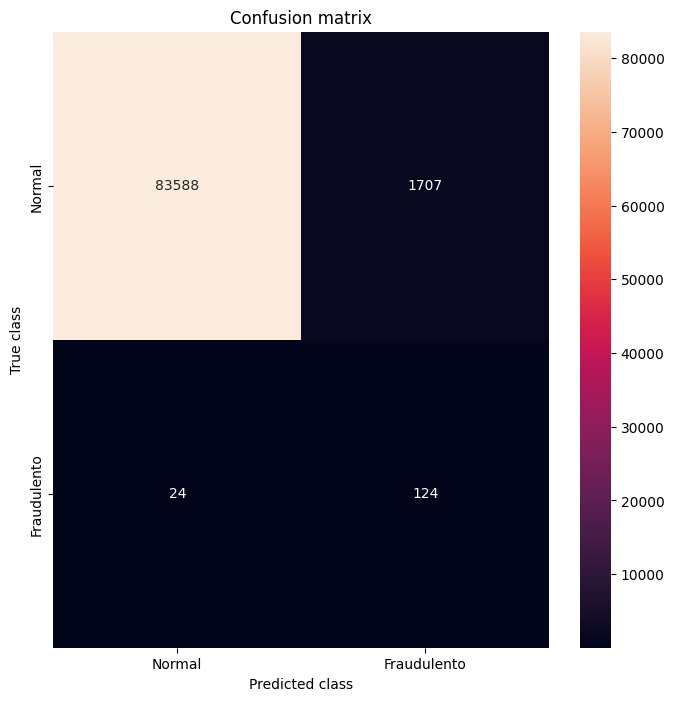

In [17]:
bbc = BalancedBaggingClassifier(estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)

#Train the classifier.
bbc.fit(X_train, y_train)
pred_y = bbc.predict(X_test)
mostrar_resultados(y_test, pred_y)

In [18]:
print(classification_report(y_test, pred_y,target_names=LABELS))

              precision    recall  f1-score   support

      Normal       1.00      0.98      0.99     85295
 Fraudulento       0.07      0.84      0.13       148

    accuracy                           0.98     85443
   macro avg       0.53      0.91      0.56     85443
weighted avg       1.00      0.98      0.99     85443

